In [30]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in C:\Users\Berne/.cache\torch\hub\pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [31]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [32]:
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import time


input_image_py = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image_py)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')

with torch.no_grad():
    startTime = time.time()
    output_py = model(input_batch)
    stopTime = time.time()
    time_py = stopTime - startTime

probabilities_py = torch.nn.functional.softmax(output_py[0], dim=0)

print(time_py * 1000) # convert from sec to milisecs


54.68034744262695


In [33]:
import cv2

input_image_py = np.array(input_image_py)

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities_py, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())


Samoyed 0.7244771718978882
wallaby 0.13937780261039734
Pomeranian 0.05874992907047272
Angora 0.022829808294773102
Arctic fox 0.012450194917619228


In [34]:
# for row in input_image_py:
#     for pix in row:
#         for val in pix:
#             print(f"{val},", end="")

In [35]:
input_image_cpp = input_image_py

# import numpy as np
# input_array_cpp = []
# with open("../bin/input_img.txt", "r")  as my_file:
#     data_line = my_file.readline()
#     for val in data_line.split(","):
#         if val == "":
#             continue
#         input_array_cpp.append(int(np.round(float(val))))

# input_image_cpp = np.array(input_array_cpp).reshape((256, 256, 3))

In [36]:
import numpy as np

output_array_cpp = []
with open("../bin/unet.output.txt", "r")  as my_file:
    time_line = my_file.readline()
    time_cpp = float(time_line)
    print(time_cpp)
    line = my_file.readline()
    for val in line.split(","):
        if val == "":
            continue
        output_array_cpp.append(int(np.round(float(val))))

mask_cpp = np.array(output_array_cpp).reshape((256, 256))


27121276115.0


In [37]:
input_image_cpp = np.array(input_image_cpp)


output_image_cpp = np.zeros((255,255,3))
for row_nr in range(0, 255):
    for col_nr in range(0, 255):
        output_image_cpp[row_nr][col_nr] = (input_image_cpp[row_nr][col_nr] * mask_cpp[row_nr][col_nr])

In [38]:
import torch
import onnxruntime as ort
import onnx


model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
input_image_pyonnxx = input_image_py
print(input_image_py.shape)
dummy_input = torch.randn(1, 3, 224, 224)


torch.onnx.export(model, dummy_input, "alexnet.onnx")


# ort_sess = ort.InferenceSession("alexnet.onnx")

# output_pyonnx = ort_sess.run(None, {"input.1": input_tensor})
# print(output_pyonnx)

model = onnx.load("alexnet.onnx")
onnx.checker.check_model(model)

ort_sess = ort.InferenceSession('alexnet.onnx')

Using cache found in C:\Users\Berne/.cache\torch\hub\pytorch_vision_v0.10.0


(1213, 1546, 3)


In [39]:
from scipy.special import softmax

with torch.no_grad():
    startTime = time.time()
    output_pyonnx = ort_sess.run(None, {'input.1': [input_tensor]})
    stopTime = time.time()
    time_pyonnx = stopTime - startTime

probabilities_pyonnx = softmax(output_pyonnx[0][0], axis=0)

print(time_pyonnx * 1000) # convert from sec to milisecs

20.037412643432617


python prediciton:
Samoyed 0.7244771718978882
wallaby 0.13937780261039734
Pomeranian 0.05874992907047272
Angora 0.022829808294773102
Arctic fox 0.012450194917619228


python onnx prediciton:
Samoyed 0.7244763970375061
wallaby 0.13937844336032867
Pomeranian 0.058749981224536896
Angora 0.022829869762063026
Arctic fox 0.012450167909264565


python finished in 0.05468034744262695 seconds
cpp finished in 2.7121276115 seconds
python onnx finished in None seconds


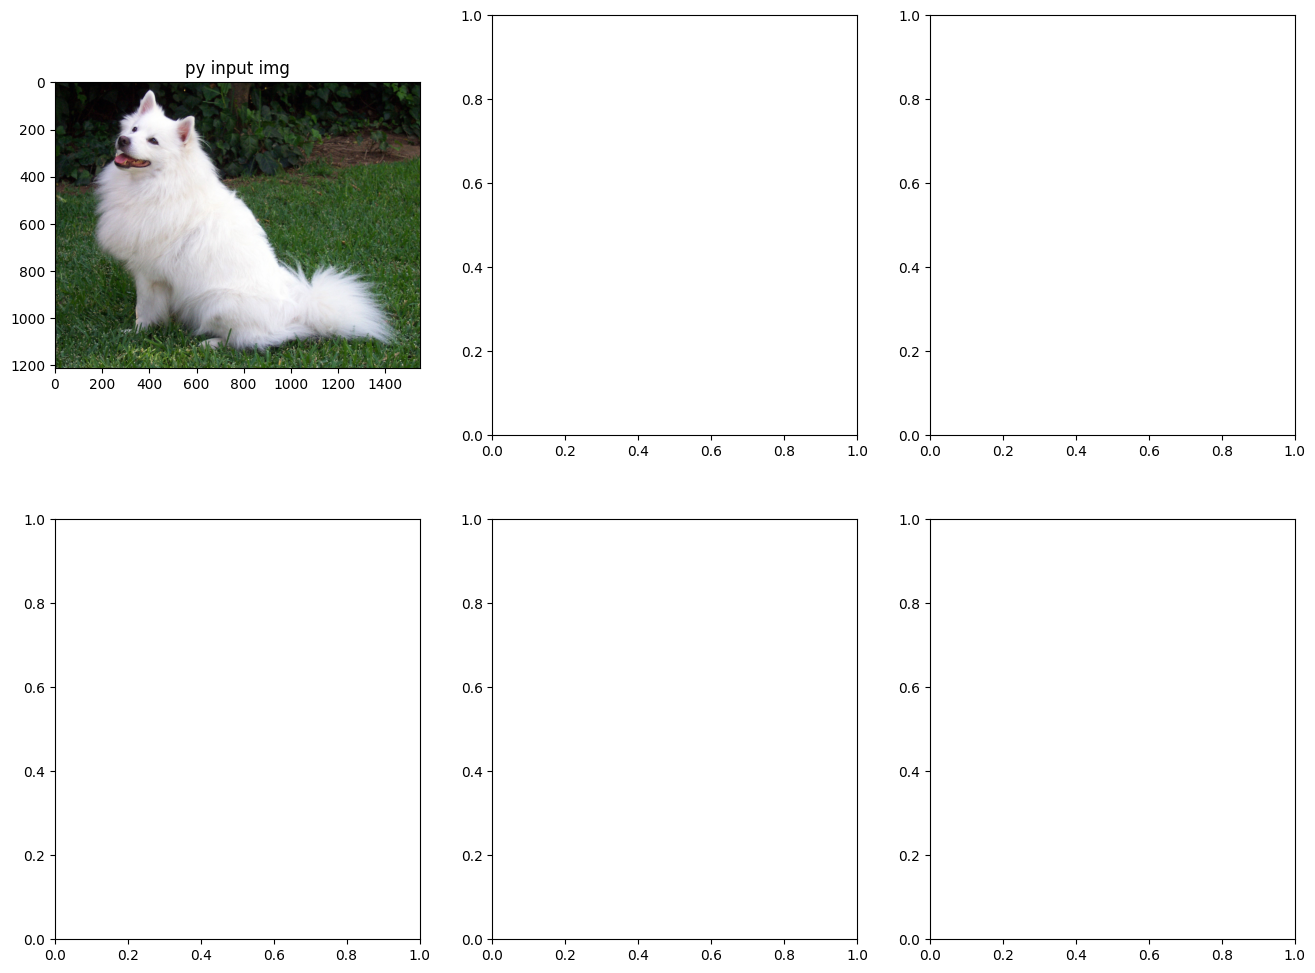

In [44]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 3)
fig.set_figwidth(16)
fig.set_figheight(12)

ax[0][0].imshow(input_image_py.astype('uint8'))
ax[0][0].set_title("py input img")

print("python prediciton:")
top5_prob, top5_catid = torch.topk(probabilities_py, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())


# ax[1][0].imshow(input_image_cpp.astype('uint8'))
# ax[1][0].set_title("cpp input img")
# ax[1][1].imshow(mask_cpp.astype('uint8'))
# ax[1][1].set_title("cpp mask")
# ax[1][2].imshow(output_image_cpp.astype('uint8'))
# ax[1][2].set_title("cpp output as mask over input img")

# ax[2][0].imshow(input_image_pyonnxx.astype('uint8'))
# ax[2][0].set_title("py onnx input image")

print("\n\npython onnx prediciton:")
top5_prob, top5_catid = torch.topk(torch.from_numpy(probabilities_pyonnx), 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())



print(f"\n\npython finished in {time_py} seconds")
print(f"cpp finished in {time_cpp / 10e9} seconds")
print(f"python onnx finished in {None} seconds")